In [7]:
"""
Modified by Kevin on 24.02.2020
"""

import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf
from tensorflow.keras import Model
import nodepy.linear_multistep_method as lm
import timeit

In [3]:
class lmmNet:
    """
    Implementation of the LMMNet
    """
    
    def __init__(self, h, X, M, scheme):
        """
        Args:
        * step size h
        * data array X with shape S x N x D 
        * M number of LMM steps
        
        """
        self.h = h
        self.X = X
        self.M = M # number of time steps
        
        # get the number of trajectories, discrete time instances, and number of feature dimensions
        self.S = X.shape[0]
        self.N = X.shape[1]
        self.D = X.shape[2]
        
        # load LMM coefficients from NodePy
        # https://nodepy.readthedocs.io/en/latest/
        if scheme == 'AB':
            coefs = lm.Adams_Bashforth(M)
        elif scheme == 'AM':
            coefs = lm.Adams_Moulton(M)
        elif scheme == 'BDF':
            coefs = lm.backward_difference_formula(M)
        else:
            raise Exception('Please choose a valid LMM scheme')
        
        self.alpha = np.float32(-coefs.alpha[::-1])
        self.beta = np.float32(coefs.beta[::-1])
        
    
        class DenseModel(Model):
            """
            A simple feed-forward network with 1 hidden layer
            """
            def __init__(self):
                super(DenseModel, self).__init__()

                self.d1 = tf.keras.layers.Dense(units=256, activation=tf.nn.tanh)
                self.d2 = tf.keras.layers.Dense(units=7, activation=None)

            def call(self, X1):
                A = X1
                A = self.d1(A)
                A = self.d2(A)
                return A
        
        self.nn = DenseModel()
                
#     def nn(self, X1):
#         """
#         Implement forward pass
        
#         Args:
#         - X1: reshaped data matrix S(N-M+1) x D
#         """
        
#         A = X1
#         L = len(self.layers) # number of layers
        
#         for l in range(0, L - 2):
#             # iterate through hidden layers
#             # Optional: include input shape for robustness
#             A = tf.keras.layers.Dense(units=self.layers[l+1], activation = tf.nn.tanh)(A)
        
#         # output layer
#         A = tf.keras.layers.Dense(units=self.layers[-1], activation=None)(A)
        
#         return A
    
    def get_F(self, X):
        """
        Output of the NN/ML model.
        
        Args:
        - X: the data matrix with shape S x (N-M+1) x D
        """
        X1 = tf.reshape(X, [-1, self.D])
        F1 = self.nn(X1)
        
        return tf.reshape(F1, [self.S, -1, self.D])
        
    def get_Y(self, X):
        """
        The linear difference (residual) operator.
        
        Args:
        - X: the data matrix with shape S x N x D
        """
        
        M = self.M
        
        # compute the difference operator
        # broadcasting from M to N to get an array for all n
        # Y has shape S x (N - M + 1) x D
        Y = self.alpha[0] * X[:, M: ,:] + self.h * self.beta[0] * self.get_F(X[:, M, :]) # for m = 0
        
        # sum over m from m = 1
        for m in range(1, M+1):
            Y += self.alpha[M] * X[:, M-m:-m, :] + self.h * self.beta[m] * self.get_F(X[:, M-m:-m, :])
        
        return Y
    
    def train(self, epochs):
        """
        Fit the model PyTorch-style
        """
        
        opt = tf.keras.optimizers.Adam()
        start_time = timeit.default_timer()
        
        for epoch in range(epochs):
            with tf.GradientTape() as tape:
                self.Y_pred = self.get_Y(self.X)
                loss = self.D * tf.reduce_mean(tf.square(self.Y_pred))
            grads = tape.gradient(loss, self.nn.trainable_weights)
            opt.apply_gradients(zip(grads, self.nn.trainable_weights))
            
            if epoch % 10 == 0:
                elapsed_time = timeit.default_timer() - start_time
                print('Epoch: %d, Loss: %.3e, Time: %.2f' %(epoch, loss, elapsed_time))

        
    def predict(self, X_reshaped):
        """
        Args:
        - X_reshaped with shape S(N-M+1) x D
        """
        return self.nn(X_reshaped)

In [8]:
# function that returns dx/dt
def f(x,t): # x is 3 x 1
    J0 = 2.5
    k1 = 100.0
    k2 = 6.0
    k3 = 16.0
    k4 = 100.0
    k5 = 1.28
    k6 = 12.0
    k = 1.8
    kappa = 13.0
    q = 4
    K1 = 0.52
    psi = 0.1
    N = 1.0
    A = 4.0

    f1 = J0 - (k1*x[0]*x[5])/(1 + (x[5]/K1)**q)
    f2 = 2*(k1*x[0]*x[5])/(1 + (x[5]/K1)**q) - k2*x[1]*(N-x[4]) - k6*x[1]*x[4]
    f3 = k2*x[1]*(N-x[4]) - k3*x[2]*(A-x[5])
    f4 = k3*x[2]*(A-x[5]) - k4*x[3]*x[4] - kappa*(x[3]-x[6])
    f5 = k2*x[1]*(N-x[4]) - k4*x[3]*x[4] - k6*x[1]*x[4]
    f6 = -2*(k1*x[0]*x[5])/(1 + (x[5]/K1)**q) + 2*k3*x[2]*(A-x[5]) - k5*x[5]
    f7 = psi*kappa*(x[3]-x[6]) - k*x[6]

    f = np.array([f1,f2,f3,f4,f5,f6,f7])
    return f

# time points
t_star = np.arange(0,10,0.01)

S1 = np.random.uniform(0.15,1.60,1)
S2 = np.random.uniform(0.19,2.16,1)
S3 = np.random.uniform(0.04,0.20,1)
S4 = np.random.uniform(0.10,0.35,1)
S5 = np.random.uniform(0.08,0.30,1)
S6 = np.random.uniform(0.14,2.67,1)
S7 = np.random.uniform(0.05,0.10,1)

# initial condition
x0 = np.array([S1,S2,S3,S4,S5,S6,S7]).flatten()

# solve ODE
X_star = odeint(f, x0, t_star)

noise = 0.00

skip = 1
dt = t_star[skip] - t_star[0]
X_train = X_star[0::skip,:]
X_train = X_train + noise*X_train.std(0)*np.random.randn(X_train.shape[0], X_train.shape[1])

X_train = np.reshape(X_train, (1,X_train.shape[0],X_train.shape[1]))

layers = [7, 256, 7]

M = 1
scheme = 'AM'
model = lmmNet(dt, X_train, M, scheme)

N_Iter = 50000
model.train(N_Iter)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 0, Loss: 7.918e-03, Time: 0.16
Epoch: 10, Loss: 7.666e-03, Time: 0.73
Epoch: 20, Loss: 7.438e-03, Time: 1.35
Epoch: 30, Loss: 7.207e-03, Time: 1.95
Epoch: 40, Loss: 6.969e-03, Time: 2.56
Epoch: 50, Loss: 6.721e-03, Time: 3.16
Epoch: 60, Loss: 6.464e-03, Time: 3.76
Epoch: 70, Loss: 6.199e-03, Time: 4.36
Epoch: 80, Loss: 5.929e-03, Time: 4.95
Epoch: 90, Loss: 5.659e-03, Time: 5.54
Epoch: 100, Loss: 5.392e-03, Time: 6.14
Epoch: 110, Loss: 5.134e-03, Time: 6.95
Epoch: 120, Loss: 4.889e-03, Time: 7.69

Epoch: 1810, Loss: 1.688e-04, Time: 105.23
Epoch: 1820, Loss: 1.663e-04, Time: 105.77
Epoch: 1830, Loss: 1.638e-04, Time: 106.31
Epoch: 1840, Loss: 1.613e-04, Time: 106.83
Epoch: 1850, Loss: 1.590e-04, Time: 107.36
Epoch: 1860, Loss: 1.566e-04, Time: 107.88
Epoch: 1870, Loss: 1.543e-04, Time: 108.41
Epoch: 1880, Loss: 1.523e-04, Time: 108.93
Epoch: 1890, Loss: 1.499e-04, Time: 109.46
Epoch: 1900, Loss: 1.478e-04, Time: 109.99
Epoch: 1910, Loss: 1.457e-04, Time: 110.51
Epoch: 1920, Loss: 1.437e-04, Time: 111.03
Epoch: 1930, Loss: 1.417e-04, Time: 111.55
Epoch: 1940, Loss: 1.398e-04, Time: 112.08
Epoch: 1950, Loss: 1.379e-04, Time: 112.62
Epoch: 1960, Loss: 1.360e-04, Time: 113.17
Epoch: 1970, Loss: 1.342e-04, Time: 113.73
Epoch: 1980, Loss: 1.324e-04, Time: 114.27
Epoch: 1990, Loss: 1.306e-04, Time: 114.81
Epoch: 2000, Loss: 1.289e-04, Time: 115.34
Epoch: 2010, Loss: 1.272e-04, Time: 115.87
Epoch: 2020, Loss: 1.258e-04, Time: 116.40
Epoch: 2030, Loss: 1.241e-04, Time: 116.93
Epoch: 2040

Epoch: 3720, Loss: 3.625e-05, Time: 206.82
Epoch: 3730, Loss: 3.606e-05, Time: 207.43
Epoch: 3740, Loss: 3.588e-05, Time: 207.97
Epoch: 3750, Loss: 3.570e-05, Time: 208.51
Epoch: 3760, Loss: 3.552e-05, Time: 209.04
Epoch: 3770, Loss: 3.535e-05, Time: 209.62
Epoch: 3780, Loss: 3.517e-05, Time: 210.15
Epoch: 3790, Loss: 3.499e-05, Time: 210.68
Epoch: 3800, Loss: 3.484e-05, Time: 211.21
Epoch: 3810, Loss: 3.539e-05, Time: 211.74
Epoch: 3820, Loss: 3.452e-05, Time: 212.26
Epoch: 3830, Loss: 3.438e-05, Time: 212.81
Epoch: 3840, Loss: 3.414e-05, Time: 213.33
Epoch: 3850, Loss: 3.399e-05, Time: 213.86
Epoch: 3860, Loss: 3.382e-05, Time: 214.39
Epoch: 3870, Loss: 3.366e-05, Time: 214.92
Epoch: 3880, Loss: 3.350e-05, Time: 215.44
Epoch: 3890, Loss: 3.334e-05, Time: 215.97
Epoch: 3900, Loss: 3.318e-05, Time: 216.53
Epoch: 3910, Loss: 3.302e-05, Time: 217.06
Epoch: 3920, Loss: 3.286e-05, Time: 217.59
Epoch: 3930, Loss: 3.270e-05, Time: 218.11
Epoch: 3940, Loss: 3.254e-05, Time: 218.64
Epoch: 3950

Epoch: 5630, Loss: 1.678e-05, Time: 307.87
Epoch: 5640, Loss: 1.673e-05, Time: 308.41
Epoch: 5650, Loss: 1.668e-05, Time: 308.93
Epoch: 5660, Loss: 1.663e-05, Time: 309.46
Epoch: 5670, Loss: 1.658e-05, Time: 309.99
Epoch: 5680, Loss: 1.653e-05, Time: 310.51
Epoch: 5690, Loss: 1.648e-05, Time: 311.03
Epoch: 5700, Loss: 1.643e-05, Time: 311.56
Epoch: 5710, Loss: 1.639e-05, Time: 312.07
Epoch: 5720, Loss: 1.634e-05, Time: 312.60
Epoch: 5730, Loss: 1.629e-05, Time: 313.12
Epoch: 5740, Loss: 1.624e-05, Time: 313.65
Epoch: 5750, Loss: 1.619e-05, Time: 314.17
Epoch: 5760, Loss: 1.622e-05, Time: 314.69
Epoch: 5770, Loss: 1.658e-05, Time: 315.22
Epoch: 5780, Loss: 1.613e-05, Time: 315.75
Epoch: 5790, Loss: 1.603e-05, Time: 316.27
Epoch: 5800, Loss: 1.599e-05, Time: 316.80
Epoch: 5810, Loss: 1.592e-05, Time: 317.32
Epoch: 5820, Loss: 1.588e-05, Time: 317.85
Epoch: 5830, Loss: 1.583e-05, Time: 318.37
Epoch: 5840, Loss: 1.579e-05, Time: 318.90
Epoch: 5850, Loss: 1.574e-05, Time: 319.42
Epoch: 5860

Epoch: 7540, Loss: 1.139e-05, Time: 408.90
Epoch: 7550, Loss: 1.079e-05, Time: 409.44
Epoch: 7560, Loss: 1.081e-05, Time: 409.97
Epoch: 7570, Loss: 1.074e-05, Time: 410.50
Epoch: 7580, Loss: 1.071e-05, Time: 411.02
Epoch: 7590, Loss: 1.070e-05, Time: 411.55
Epoch: 7600, Loss: 1.067e-05, Time: 412.07
Epoch: 7610, Loss: 1.065e-05, Time: 412.60
Epoch: 7620, Loss: 1.064e-05, Time: 413.12
Epoch: 7630, Loss: 1.062e-05, Time: 413.64
Epoch: 7640, Loss: 1.060e-05, Time: 414.16
Epoch: 7650, Loss: 1.058e-05, Time: 414.69
Epoch: 7660, Loss: 1.056e-05, Time: 415.22
Epoch: 7670, Loss: 1.054e-05, Time: 415.75
Epoch: 7680, Loss: 1.052e-05, Time: 416.27
Epoch: 7690, Loss: 1.050e-05, Time: 416.80
Epoch: 7700, Loss: 1.048e-05, Time: 417.32
Epoch: 7710, Loss: 1.047e-05, Time: 417.85
Epoch: 7720, Loss: 1.063e-05, Time: 418.37
Epoch: 7730, Loss: 1.044e-05, Time: 418.92
Epoch: 7740, Loss: 1.061e-05, Time: 419.45
Epoch: 7750, Loss: 1.039e-05, Time: 419.97
Epoch: 7760, Loss: 1.040e-05, Time: 420.50
Epoch: 7770

Epoch: 9450, Loss: 7.974e-06, Time: 509.95
Epoch: 9460, Loss: 7.962e-06, Time: 510.50
Epoch: 9470, Loss: 7.951e-06, Time: 511.02
Epoch: 9480, Loss: 7.992e-06, Time: 511.55
Epoch: 9490, Loss: 8.848e-06, Time: 512.07
Epoch: 9500, Loss: 8.185e-06, Time: 512.59
Epoch: 9510, Loss: 7.937e-06, Time: 513.13
Epoch: 9520, Loss: 7.896e-06, Time: 513.66
Epoch: 9530, Loss: 7.887e-06, Time: 514.18
Epoch: 9540, Loss: 7.879e-06, Time: 514.71
Epoch: 9550, Loss: 7.866e-06, Time: 515.23
Epoch: 9560, Loss: 7.853e-06, Time: 515.75
Epoch: 9570, Loss: 7.842e-06, Time: 516.28
Epoch: 9580, Loss: 7.832e-06, Time: 516.80
Epoch: 9590, Loss: 7.821e-06, Time: 517.37
Epoch: 9600, Loss: 7.810e-06, Time: 517.90
Epoch: 9610, Loss: 7.799e-06, Time: 518.43
Epoch: 9620, Loss: 7.789e-06, Time: 518.95
Epoch: 9630, Loss: 7.778e-06, Time: 519.47
Epoch: 9640, Loss: 7.767e-06, Time: 520.00
Epoch: 9650, Loss: 7.756e-06, Time: 520.53
Epoch: 9660, Loss: 7.745e-06, Time: 521.05
Epoch: 9670, Loss: 7.735e-06, Time: 521.58
Epoch: 9680

Epoch: 11330, Loss: 6.221e-06, Time: 609.06
Epoch: 11340, Loss: 6.219e-06, Time: 609.61
Epoch: 11350, Loss: 6.396e-06, Time: 610.14
Epoch: 11360, Loss: 6.248e-06, Time: 610.67
Epoch: 11370, Loss: 6.209e-06, Time: 611.19
Epoch: 11380, Loss: 6.229e-06, Time: 611.72
Epoch: 11390, Loss: 6.189e-06, Time: 612.24
Epoch: 11400, Loss: 6.169e-06, Time: 612.76
Epoch: 11410, Loss: 6.160e-06, Time: 613.33
Epoch: 11420, Loss: 6.152e-06, Time: 613.87
Epoch: 11430, Loss: 6.145e-06, Time: 614.43
Epoch: 11440, Loss: 6.137e-06, Time: 614.96
Epoch: 11450, Loss: 6.130e-06, Time: 615.49
Epoch: 11460, Loss: 6.122e-06, Time: 616.01
Epoch: 11470, Loss: 6.115e-06, Time: 616.54
Epoch: 11480, Loss: 6.107e-06, Time: 617.06
Epoch: 11490, Loss: 6.099e-06, Time: 617.59
Epoch: 11500, Loss: 6.092e-06, Time: 618.11
Epoch: 11510, Loss: 6.094e-06, Time: 618.64
Epoch: 11520, Loss: 6.725e-06, Time: 619.16
Epoch: 11530, Loss: 6.474e-06, Time: 619.69
Epoch: 11540, Loss: 6.069e-06, Time: 620.21
Epoch: 11550, Loss: 6.108e-06, T

Epoch: 13200, Loss: 5.929e-06, Time: 712.05
Epoch: 13210, Loss: 5.133e-06, Time: 712.63
Epoch: 13220, Loss: 5.055e-06, Time: 713.26
Epoch: 13230, Loss: 5.021e-06, Time: 713.90
Epoch: 13240, Loss: 5.000e-06, Time: 714.49
Epoch: 13250, Loss: 4.995e-06, Time: 715.27
Epoch: 13260, Loss: 4.986e-06, Time: 715.90
Epoch: 13270, Loss: 4.980e-06, Time: 716.45
Epoch: 13280, Loss: 4.975e-06, Time: 717.01
Epoch: 13290, Loss: 4.970e-06, Time: 717.55
Epoch: 13300, Loss: 4.964e-06, Time: 718.10
Epoch: 13310, Loss: 4.959e-06, Time: 718.64
Epoch: 13320, Loss: 4.954e-06, Time: 719.18
Epoch: 13330, Loss: 4.948e-06, Time: 719.72
Epoch: 13340, Loss: 4.943e-06, Time: 720.44
Epoch: 13350, Loss: 4.937e-06, Time: 721.04
Epoch: 13360, Loss: 4.932e-06, Time: 721.73
Epoch: 13370, Loss: 4.927e-06, Time: 722.46
Epoch: 13380, Loss: 4.923e-06, Time: 723.04
Epoch: 13390, Loss: 5.039e-06, Time: 723.74
Epoch: 13400, Loss: 5.147e-06, Time: 724.51
Epoch: 13410, Loss: 5.028e-06, Time: 725.06
Epoch: 13420, Loss: 4.926e-06, T

Epoch: 15070, Loss: 4.148e-06, Time: 822.97
Epoch: 15080, Loss: 4.144e-06, Time: 823.52
Epoch: 15090, Loss: 4.140e-06, Time: 824.06
Epoch: 15100, Loss: 4.136e-06, Time: 824.59
Epoch: 15110, Loss: 4.132e-06, Time: 825.12
Epoch: 15120, Loss: 4.128e-06, Time: 825.65
Epoch: 15130, Loss: 4.124e-06, Time: 826.18
Epoch: 15140, Loss: 4.122e-06, Time: 826.71
Epoch: 15150, Loss: 4.220e-06, Time: 827.24
Epoch: 15160, Loss: 4.502e-06, Time: 827.77
Epoch: 15170, Loss: 4.109e-06, Time: 828.31
Epoch: 15180, Loss: 4.170e-06, Time: 828.85
Epoch: 15190, Loss: 4.109e-06, Time: 829.38
Epoch: 15200, Loss: 4.098e-06, Time: 829.92
Epoch: 15210, Loss: 4.095e-06, Time: 830.45
Epoch: 15220, Loss: 4.089e-06, Time: 830.98
Epoch: 15230, Loss: 4.084e-06, Time: 831.52
Epoch: 15240, Loss: 4.080e-06, Time: 832.05
Epoch: 15250, Loss: 4.076e-06, Time: 832.59
Epoch: 15260, Loss: 4.072e-06, Time: 833.13
Epoch: 15270, Loss: 4.068e-06, Time: 833.66
Epoch: 15280, Loss: 4.064e-06, Time: 834.19
Epoch: 15290, Loss: 4.060e-06, T

Epoch: 16940, Loss: 3.480e-06, Time: 922.62
Epoch: 16950, Loss: 3.476e-06, Time: 923.17
Epoch: 16960, Loss: 3.473e-06, Time: 923.70
Epoch: 16970, Loss: 3.469e-06, Time: 924.23
Epoch: 16980, Loss: 3.466e-06, Time: 924.75
Epoch: 16990, Loss: 3.463e-06, Time: 925.28
Epoch: 17000, Loss: 3.460e-06, Time: 925.81
Epoch: 17010, Loss: 3.457e-06, Time: 926.34
Epoch: 17020, Loss: 3.453e-06, Time: 926.87
Epoch: 17030, Loss: 3.450e-06, Time: 927.41
Epoch: 17040, Loss: 3.447e-06, Time: 927.97
Epoch: 17050, Loss: 3.444e-06, Time: 928.57
Epoch: 17060, Loss: 3.441e-06, Time: 929.11
Epoch: 17070, Loss: 3.459e-06, Time: 929.66
Epoch: 17080, Loss: 4.165e-06, Time: 930.22
Epoch: 17090, Loss: 3.740e-06, Time: 930.77
Epoch: 17100, Loss: 3.458e-06, Time: 931.31
Epoch: 17110, Loss: 3.442e-06, Time: 931.85
Epoch: 17120, Loss: 3.435e-06, Time: 932.38
Epoch: 17130, Loss: 3.419e-06, Time: 932.93
Epoch: 17140, Loss: 3.416e-06, Time: 933.46
Epoch: 17150, Loss: 3.413e-06, Time: 934.00
Epoch: 17160, Loss: 3.410e-06, T

Epoch: 18800, Loss: 2.948e-06, Time: 1023.50
Epoch: 18810, Loss: 2.945e-06, Time: 1024.26
Epoch: 18820, Loss: 2.943e-06, Time: 1024.83
Epoch: 18830, Loss: 2.940e-06, Time: 1025.40
Epoch: 18840, Loss: 2.937e-06, Time: 1025.95
Epoch: 18850, Loss: 2.935e-06, Time: 1026.51
Epoch: 18860, Loss: 2.965e-06, Time: 1027.06
Epoch: 18870, Loss: 4.333e-06, Time: 1027.60
Epoch: 18880, Loss: 2.951e-06, Time: 1028.14
Epoch: 18890, Loss: 2.966e-06, Time: 1028.68
Epoch: 18900, Loss: 2.965e-06, Time: 1029.22
Epoch: 18910, Loss: 2.937e-06, Time: 1029.81
Epoch: 18920, Loss: 2.919e-06, Time: 1030.36
Epoch: 18930, Loss: 2.916e-06, Time: 1030.93
Epoch: 18940, Loss: 2.914e-06, Time: 1031.51
Epoch: 18950, Loss: 2.910e-06, Time: 1032.08
Epoch: 18960, Loss: 2.908e-06, Time: 1032.64
Epoch: 18970, Loss: 2.906e-06, Time: 1033.21
Epoch: 18980, Loss: 2.903e-06, Time: 1033.83
Epoch: 18990, Loss: 2.901e-06, Time: 1035.08
Epoch: 19000, Loss: 2.898e-06, Time: 1035.74
Epoch: 19010, Loss: 2.896e-06, Time: 1036.41
Epoch: 190

Epoch: 20630, Loss: 2.812e-06, Time: 1120.43
Epoch: 20640, Loss: 2.586e-06, Time: 1120.96
Epoch: 20650, Loss: 2.717e-06, Time: 1121.48
Epoch: 20660, Loss: 2.591e-06, Time: 1122.00
Epoch: 20670, Loss: 2.529e-06, Time: 1122.52
Epoch: 20680, Loss: 2.537e-06, Time: 1123.03
Epoch: 20690, Loss: 2.527e-06, Time: 1123.54
Epoch: 20700, Loss: 2.524e-06, Time: 1124.05
Epoch: 20710, Loss: 2.522e-06, Time: 1124.56
Epoch: 20720, Loss: 2.520e-06, Time: 1125.08
Epoch: 20730, Loss: 2.518e-06, Time: 1125.60
Epoch: 20740, Loss: 2.516e-06, Time: 1126.11
Epoch: 20750, Loss: 2.514e-06, Time: 1126.63
Epoch: 20760, Loss: 2.512e-06, Time: 1127.14
Epoch: 20770, Loss: 2.510e-06, Time: 1127.65
Epoch: 20780, Loss: 2.509e-06, Time: 1128.17
Epoch: 20790, Loss: 2.520e-06, Time: 1128.68
Epoch: 20800, Loss: 2.509e-06, Time: 1129.20
Epoch: 20810, Loss: 2.503e-06, Time: 1129.71
Epoch: 20820, Loss: 2.500e-06, Time: 1130.22
Epoch: 20830, Loss: 2.498e-06, Time: 1130.73
Epoch: 20840, Loss: 2.498e-06, Time: 1131.24
Epoch: 208

Epoch: 22460, Loss: 2.216e-06, Time: 1215.23
Epoch: 22470, Loss: 2.215e-06, Time: 1215.76
Epoch: 22480, Loss: 2.213e-06, Time: 1216.28
Epoch: 22490, Loss: 2.211e-06, Time: 1216.81
Epoch: 22500, Loss: 2.210e-06, Time: 1217.32
Epoch: 22510, Loss: 2.208e-06, Time: 1217.84
Epoch: 22520, Loss: 2.207e-06, Time: 1218.34
Epoch: 22530, Loss: 2.205e-06, Time: 1218.86
Epoch: 22540, Loss: 2.204e-06, Time: 1219.37
Epoch: 22550, Loss: 2.219e-06, Time: 1219.88
Epoch: 22560, Loss: 2.205e-06, Time: 1220.39
Epoch: 22570, Loss: 2.203e-06, Time: 1220.91
Epoch: 22580, Loss: 2.232e-06, Time: 1221.42
Epoch: 22590, Loss: 2.808e-06, Time: 1221.94
Epoch: 22600, Loss: 2.408e-06, Time: 1222.46
Epoch: 22610, Loss: 2.268e-06, Time: 1222.97
Epoch: 22620, Loss: 2.201e-06, Time: 1223.52
Epoch: 22630, Loss: 2.190e-06, Time: 1224.04
Epoch: 22640, Loss: 2.189e-06, Time: 1224.56
Epoch: 22650, Loss: 2.187e-06, Time: 1225.07
Epoch: 22660, Loss: 2.185e-06, Time: 1225.58
Epoch: 22670, Loss: 2.184e-06, Time: 1226.10
Epoch: 226

Epoch: 24290, Loss: 1.962e-06, Time: 1310.00
Epoch: 24300, Loss: 1.961e-06, Time: 1310.53
Epoch: 24310, Loss: 1.961e-06, Time: 1311.05
Epoch: 24320, Loss: 2.032e-06, Time: 1311.56
Epoch: 24330, Loss: 2.724e-06, Time: 1312.08
Epoch: 24340, Loss: 1.958e-06, Time: 1312.59
Epoch: 24350, Loss: 2.053e-06, Time: 1313.10
Epoch: 24360, Loss: 1.955e-06, Time: 1313.62
Epoch: 24370, Loss: 1.965e-06, Time: 1314.13
Epoch: 24380, Loss: 1.952e-06, Time: 1314.64
Epoch: 24390, Loss: 1.951e-06, Time: 1315.16
Epoch: 24400, Loss: 1.949e-06, Time: 1315.67
Epoch: 24410, Loss: 1.948e-06, Time: 1316.19
Epoch: 24420, Loss: 1.946e-06, Time: 1316.70
Epoch: 24430, Loss: 1.945e-06, Time: 1317.22
Epoch: 24440, Loss: 1.944e-06, Time: 1317.73
Epoch: 24450, Loss: 1.943e-06, Time: 1318.25
Epoch: 24460, Loss: 1.943e-06, Time: 1318.76
Epoch: 24470, Loss: 1.941e-06, Time: 1319.28
Epoch: 24480, Loss: 1.940e-06, Time: 1319.80
Epoch: 24490, Loss: 1.938e-06, Time: 1320.32
Epoch: 24500, Loss: 1.937e-06, Time: 1320.86
Epoch: 245

Epoch: 26120, Loss: 1.969e-06, Time: 1405.45
Epoch: 26130, Loss: 1.763e-06, Time: 1405.99
Epoch: 26140, Loss: 1.784e-06, Time: 1406.52
Epoch: 26150, Loss: 1.757e-06, Time: 1407.04
Epoch: 26160, Loss: 1.758e-06, Time: 1407.57
Epoch: 26170, Loss: 1.753e-06, Time: 1408.08
Epoch: 26180, Loss: 1.753e-06, Time: 1408.67
Epoch: 26190, Loss: 1.751e-06, Time: 1409.21
Epoch: 26200, Loss: 1.750e-06, Time: 1409.74
Epoch: 26210, Loss: 1.749e-06, Time: 1410.30
Epoch: 26220, Loss: 1.748e-06, Time: 1410.83
Epoch: 26230, Loss: 1.747e-06, Time: 1411.35
Epoch: 26240, Loss: 1.746e-06, Time: 1411.87
Epoch: 26250, Loss: 1.745e-06, Time: 1412.39
Epoch: 26260, Loss: 1.744e-06, Time: 1412.92
Epoch: 26270, Loss: 1.743e-06, Time: 1413.44
Epoch: 26280, Loss: 1.742e-06, Time: 1413.96
Epoch: 26290, Loss: 1.741e-06, Time: 1414.48
Epoch: 26300, Loss: 1.742e-06, Time: 1414.99
Epoch: 26310, Loss: 1.778e-06, Time: 1415.51
Epoch: 26320, Loss: 2.813e-06, Time: 1416.01
Epoch: 26330, Loss: 1.930e-06, Time: 1416.53
Epoch: 263

Epoch: 27950, Loss: 1.592e-06, Time: 1500.55
Epoch: 27960, Loss: 1.593e-06, Time: 1501.08
Epoch: 27970, Loss: 1.860e-06, Time: 1501.61
Epoch: 27980, Loss: 1.615e-06, Time: 1502.12
Epoch: 27990, Loss: 1.799e-06, Time: 1502.65
Epoch: 28000, Loss: 1.639e-06, Time: 1503.16
Epoch: 28010, Loss: 1.587e-06, Time: 1503.67
Epoch: 28020, Loss: 1.596e-06, Time: 1504.19
Epoch: 28030, Loss: 1.585e-06, Time: 1504.71
Epoch: 28040, Loss: 1.585e-06, Time: 1505.22
Epoch: 28050, Loss: 1.583e-06, Time: 1505.75
Epoch: 28060, Loss: 1.582e-06, Time: 1506.26
Epoch: 28070, Loss: 1.581e-06, Time: 1506.77
Epoch: 28080, Loss: 1.580e-06, Time: 1507.28
Epoch: 28090, Loss: 1.579e-06, Time: 1507.80
Epoch: 28100, Loss: 1.579e-06, Time: 1508.32
Epoch: 28110, Loss: 1.578e-06, Time: 1508.84
Epoch: 28120, Loss: 1.577e-06, Time: 1509.35
Epoch: 28130, Loss: 1.576e-06, Time: 1509.88
Epoch: 28140, Loss: 1.575e-06, Time: 1510.39
Epoch: 28150, Loss: 1.575e-06, Time: 1510.90
Epoch: 28160, Loss: 1.574e-06, Time: 1511.41
Epoch: 281

Epoch: 29780, Loss: 1.456e-06, Time: 1598.28
Epoch: 29790, Loss: 1.452e-06, Time: 1598.83
Epoch: 29800, Loss: 1.451e-06, Time: 1599.37
Epoch: 29810, Loss: 1.450e-06, Time: 1599.92
Epoch: 29820, Loss: 1.449e-06, Time: 1600.44
Epoch: 29830, Loss: 1.448e-06, Time: 1600.99
Epoch: 29840, Loss: 1.447e-06, Time: 1601.52
Epoch: 29850, Loss: 1.447e-06, Time: 1602.04
Epoch: 29860, Loss: 1.446e-06, Time: 1602.56
Epoch: 29870, Loss: 1.445e-06, Time: 1603.08
Epoch: 29880, Loss: 1.445e-06, Time: 1603.59
Epoch: 29890, Loss: 1.444e-06, Time: 1604.10
Epoch: 29900, Loss: 1.445e-06, Time: 1604.62
Epoch: 29910, Loss: 1.443e-06, Time: 1605.16
Epoch: 29920, Loss: 1.442e-06, Time: 1605.69
Epoch: 29930, Loss: 1.442e-06, Time: 1606.20
Epoch: 29940, Loss: 1.446e-06, Time: 1606.72
Epoch: 29950, Loss: 1.630e-06, Time: 1607.23
Epoch: 29960, Loss: 1.545e-06, Time: 1607.76
Epoch: 29970, Loss: 1.468e-06, Time: 1608.29
Epoch: 29980, Loss: 1.502e-06, Time: 1608.81
Epoch: 29990, Loss: 1.445e-06, Time: 1609.32
Epoch: 300

Epoch: 31610, Loss: 1.338e-06, Time: 1694.37
Epoch: 31620, Loss: 1.471e-06, Time: 1694.90
Epoch: 31630, Loss: 1.664e-06, Time: 1695.41
Epoch: 31640, Loss: 1.359e-06, Time: 1695.96
Epoch: 31650, Loss: 1.412e-06, Time: 1696.48
Epoch: 31660, Loss: 1.332e-06, Time: 1696.99
Epoch: 31670, Loss: 1.340e-06, Time: 1697.51
Epoch: 31680, Loss: 1.333e-06, Time: 1698.04
Epoch: 31690, Loss: 1.330e-06, Time: 1698.55
Epoch: 31700, Loss: 1.329e-06, Time: 1699.07
Epoch: 31710, Loss: 1.329e-06, Time: 1699.59
Epoch: 31720, Loss: 1.328e-06, Time: 1700.12
Epoch: 31730, Loss: 1.328e-06, Time: 1700.66
Epoch: 31740, Loss: 1.327e-06, Time: 1701.19
Epoch: 31750, Loss: 1.326e-06, Time: 1701.71
Epoch: 31760, Loss: 1.326e-06, Time: 1702.23
Epoch: 31770, Loss: 1.325e-06, Time: 1702.74
Epoch: 31780, Loss: 1.325e-06, Time: 1703.26
Epoch: 31790, Loss: 1.324e-06, Time: 1703.78
Epoch: 31800, Loss: 1.333e-06, Time: 1704.30
Epoch: 31810, Loss: 1.768e-06, Time: 1704.81
Epoch: 31820, Loss: 1.440e-06, Time: 1705.32
Epoch: 318

Epoch: 33440, Loss: 1.235e-06, Time: 1789.09
Epoch: 33450, Loss: 1.234e-06, Time: 1789.62
Epoch: 33460, Loss: 1.234e-06, Time: 1790.14
Epoch: 33470, Loss: 1.233e-06, Time: 1790.66
Epoch: 33480, Loss: 1.233e-06, Time: 1791.18
Epoch: 33490, Loss: 1.235e-06, Time: 1791.70
Epoch: 33500, Loss: 1.308e-06, Time: 1792.21
Epoch: 33510, Loss: 2.094e-06, Time: 1792.78
Epoch: 33520, Loss: 1.239e-06, Time: 1793.32
Epoch: 33530, Loss: 1.329e-06, Time: 1793.85
Epoch: 33540, Loss: 1.243e-06, Time: 1794.37
Epoch: 33550, Loss: 1.237e-06, Time: 1794.90
Epoch: 33560, Loss: 1.231e-06, Time: 1795.42
Epoch: 33570, Loss: 1.230e-06, Time: 1795.95
Epoch: 33580, Loss: 1.228e-06, Time: 1796.48
Epoch: 33590, Loss: 1.228e-06, Time: 1797.00
Epoch: 33600, Loss: 1.227e-06, Time: 1797.52
Epoch: 33610, Loss: 1.226e-06, Time: 1798.04
Epoch: 33620, Loss: 1.226e-06, Time: 1798.57
Epoch: 33630, Loss: 1.225e-06, Time: 1799.09
Epoch: 33640, Loss: 1.225e-06, Time: 1799.61
Epoch: 33650, Loss: 1.224e-06, Time: 1800.13
Epoch: 336

Epoch: 35270, Loss: 1.149e-06, Time: 1888.03
Epoch: 35280, Loss: 1.149e-06, Time: 1888.64
Epoch: 35290, Loss: 1.173e-06, Time: 1889.21
Epoch: 35300, Loss: 2.444e-06, Time: 1889.77
Epoch: 35310, Loss: 1.392e-06, Time: 1890.35
Epoch: 35320, Loss: 1.279e-06, Time: 1890.88
Epoch: 35330, Loss: 1.148e-06, Time: 1891.41
Epoch: 35340, Loss: 1.162e-06, Time: 1891.93
Epoch: 35350, Loss: 1.149e-06, Time: 1892.46
Epoch: 35360, Loss: 1.147e-06, Time: 1892.98
Epoch: 35370, Loss: 1.146e-06, Time: 1893.50
Epoch: 35380, Loss: 1.145e-06, Time: 1894.02
Epoch: 35390, Loss: 1.144e-06, Time: 1894.55
Epoch: 35400, Loss: 1.144e-06, Time: 1895.14
Epoch: 35410, Loss: 1.143e-06, Time: 1895.77
Epoch: 35420, Loss: 1.143e-06, Time: 1896.32
Epoch: 35430, Loss: 1.143e-06, Time: 1896.85
Epoch: 35440, Loss: 1.142e-06, Time: 1897.36
Epoch: 35450, Loss: 1.142e-06, Time: 1897.88
Epoch: 35460, Loss: 1.141e-06, Time: 1898.40
Epoch: 35470, Loss: 1.141e-06, Time: 1899.03
Epoch: 35480, Loss: 1.140e-06, Time: 1899.65
Epoch: 354

Epoch: 37100, Loss: 1.076e-06, Time: 1984.90
Epoch: 37110, Loss: 1.075e-06, Time: 1985.44
Epoch: 37120, Loss: 1.075e-06, Time: 1985.96
Epoch: 37130, Loss: 1.074e-06, Time: 1986.48
Epoch: 37140, Loss: 1.074e-06, Time: 1987.00
Epoch: 37150, Loss: 1.074e-06, Time: 1987.51
Epoch: 37160, Loss: 1.073e-06, Time: 1988.03
Epoch: 37170, Loss: 1.073e-06, Time: 1988.54
Epoch: 37180, Loss: 1.072e-06, Time: 1989.06
Epoch: 37190, Loss: 1.072e-06, Time: 1989.60
Epoch: 37200, Loss: 1.093e-06, Time: 1990.13
Epoch: 37210, Loss: 2.103e-06, Time: 1990.65
Epoch: 37220, Loss: 1.487e-06, Time: 1991.16
Epoch: 37230, Loss: 1.088e-06, Time: 1991.68
Epoch: 37240, Loss: 1.111e-06, Time: 1992.21
Epoch: 37250, Loss: 1.076e-06, Time: 1992.73
Epoch: 37260, Loss: 1.075e-06, Time: 1993.24
Epoch: 37270, Loss: 1.069e-06, Time: 1993.76
Epoch: 37280, Loss: 1.070e-06, Time: 1994.28
Epoch: 37290, Loss: 1.069e-06, Time: 1994.79
Epoch: 37300, Loss: 1.068e-06, Time: 1995.31
Epoch: 37310, Loss: 1.068e-06, Time: 1995.85
Epoch: 373

Epoch: 38930, Loss: 1.011e-06, Time: 2082.78
Epoch: 38940, Loss: 1.010e-06, Time: 2083.33
Epoch: 38950, Loss: 1.012e-06, Time: 2083.86
Epoch: 38960, Loss: 1.148e-06, Time: 2084.39
Epoch: 38970, Loss: 1.268e-06, Time: 2084.92
Epoch: 38980, Loss: 1.278e-06, Time: 2085.44
Epoch: 38990, Loss: 1.012e-06, Time: 2085.97
Epoch: 39000, Loss: 1.032e-06, Time: 2086.50
Epoch: 39010, Loss: 1.020e-06, Time: 2087.02
Epoch: 39020, Loss: 1.008e-06, Time: 2087.54
Epoch: 39030, Loss: 1.009e-06, Time: 2088.07
Epoch: 39040, Loss: 1.007e-06, Time: 2088.59
Epoch: 39050, Loss: 1.007e-06, Time: 2089.11
Epoch: 39060, Loss: 1.006e-06, Time: 2089.64
Epoch: 39070, Loss: 1.006e-06, Time: 2090.16
Epoch: 39080, Loss: 1.006e-06, Time: 2090.68
Epoch: 39090, Loss: 1.005e-06, Time: 2091.20
Epoch: 39100, Loss: 1.005e-06, Time: 2091.73
Epoch: 39110, Loss: 1.005e-06, Time: 2092.26
Epoch: 39120, Loss: 1.004e-06, Time: 2092.81
Epoch: 39130, Loss: 1.004e-06, Time: 2093.39
Epoch: 39140, Loss: 1.004e-06, Time: 2093.93
Epoch: 391

Epoch: 40760, Loss: 9.533e-07, Time: 2179.44
Epoch: 40770, Loss: 9.530e-07, Time: 2179.98
Epoch: 40780, Loss: 9.527e-07, Time: 2180.51
Epoch: 40790, Loss: 9.524e-07, Time: 2181.02
Epoch: 40800, Loss: 9.521e-07, Time: 2181.54
Epoch: 40810, Loss: 9.518e-07, Time: 2182.07
Epoch: 40820, Loss: 9.515e-07, Time: 2182.59
Epoch: 40830, Loss: 9.512e-07, Time: 2183.11
Epoch: 40840, Loss: 9.510e-07, Time: 2183.63
Epoch: 40850, Loss: 9.528e-07, Time: 2184.15
Epoch: 40860, Loss: 1.115e-06, Time: 2184.67
Epoch: 40870, Loss: 1.106e-06, Time: 2185.18
Epoch: 40880, Loss: 1.180e-06, Time: 2185.70
Epoch: 40890, Loss: 9.520e-07, Time: 2186.21
Epoch: 40900, Loss: 9.814e-07, Time: 2186.73
Epoch: 40910, Loss: 9.519e-07, Time: 2187.24
Epoch: 40920, Loss: 9.519e-07, Time: 2187.76
Epoch: 40930, Loss: 9.485e-07, Time: 2188.28
Epoch: 40940, Loss: 9.486e-07, Time: 2188.79
Epoch: 40950, Loss: 9.478e-07, Time: 2189.31
Epoch: 40960, Loss: 9.474e-07, Time: 2189.82
Epoch: 40970, Loss: 9.472e-07, Time: 2190.34
Epoch: 409

Epoch: 42590, Loss: 9.108e-07, Time: 2275.92
Epoch: 42600, Loss: 1.287e-06, Time: 2276.47
Epoch: 42610, Loss: 9.422e-07, Time: 2276.99
Epoch: 42620, Loss: 1.065e-06, Time: 2277.51
Epoch: 42630, Loss: 9.150e-07, Time: 2278.02
Epoch: 42640, Loss: 9.096e-07, Time: 2278.54
Epoch: 42650, Loss: 9.082e-07, Time: 2279.06
Epoch: 42660, Loss: 9.011e-07, Time: 2279.58
Epoch: 42670, Loss: 8.998e-07, Time: 2280.10
Epoch: 42680, Loss: 8.996e-07, Time: 2280.62
Epoch: 42690, Loss: 8.993e-07, Time: 2281.14
Epoch: 42700, Loss: 8.990e-07, Time: 2281.66
Epoch: 42710, Loss: 8.987e-07, Time: 2282.18
Epoch: 42720, Loss: 8.985e-07, Time: 2282.72
Epoch: 42730, Loss: 8.982e-07, Time: 2283.24
Epoch: 42740, Loss: 8.979e-07, Time: 2283.76
Epoch: 42750, Loss: 8.978e-07, Time: 2284.28
Epoch: 42760, Loss: 8.984e-07, Time: 2284.79
Epoch: 42770, Loss: 9.209e-07, Time: 2285.31
Epoch: 42780, Loss: 1.641e-06, Time: 2285.92
Epoch: 42790, Loss: 1.209e-06, Time: 2286.47
Epoch: 42800, Loss: 9.691e-07, Time: 2287.00
Epoch: 428

Epoch: 44420, Loss: 8.559e-07, Time: 2371.60
Epoch: 44430, Loss: 8.556e-07, Time: 2372.14
Epoch: 44440, Loss: 8.554e-07, Time: 2372.67
Epoch: 44450, Loss: 8.557e-07, Time: 2373.19
Epoch: 44460, Loss: 8.782e-07, Time: 2373.71
Epoch: 44470, Loss: 1.792e-06, Time: 2374.23
Epoch: 44480, Loss: 1.263e-06, Time: 2374.75
Epoch: 44490, Loss: 8.582e-07, Time: 2375.26
Epoch: 44500, Loss: 9.014e-07, Time: 2375.79
Epoch: 44510, Loss: 8.564e-07, Time: 2376.30
Epoch: 44520, Loss: 8.572e-07, Time: 2376.82
Epoch: 44530, Loss: 8.554e-07, Time: 2377.34
Epoch: 44540, Loss: 8.532e-07, Time: 2377.85
Epoch: 44550, Loss: 8.528e-07, Time: 2378.37
Epoch: 44560, Loss: 8.525e-07, Time: 2378.90
Epoch: 44570, Loss: 8.523e-07, Time: 2379.42
Epoch: 44580, Loss: 8.521e-07, Time: 2379.94
Epoch: 44590, Loss: 8.518e-07, Time: 2380.46
Epoch: 44600, Loss: 8.516e-07, Time: 2380.97
Epoch: 44610, Loss: 8.513e-07, Time: 2381.49
Epoch: 44620, Loss: 8.511e-07, Time: 2382.02
Epoch: 44630, Loss: 8.509e-07, Time: 2382.57
Epoch: 446

Epoch: 46250, Loss: 8.143e-07, Time: 2467.17
Epoch: 46260, Loss: 8.141e-07, Time: 2467.71
Epoch: 46270, Loss: 8.139e-07, Time: 2468.23
Epoch: 46280, Loss: 8.137e-07, Time: 2468.76
Epoch: 46290, Loss: 8.134e-07, Time: 2469.28
Epoch: 46300, Loss: 8.132e-07, Time: 2469.80
Epoch: 46310, Loss: 8.136e-07, Time: 2470.32
Epoch: 46320, Loss: 8.316e-07, Time: 2470.85
Epoch: 46330, Loss: 1.522e-06, Time: 2471.36
Epoch: 46340, Loss: 1.131e-06, Time: 2471.88
Epoch: 46350, Loss: 8.950e-07, Time: 2472.40
Epoch: 46360, Loss: 8.195e-07, Time: 2472.91
Epoch: 46370, Loss: 8.297e-07, Time: 2473.43
Epoch: 46380, Loss: 8.139e-07, Time: 2473.95
Epoch: 46390, Loss: 8.114e-07, Time: 2474.47
Epoch: 46400, Loss: 8.114e-07, Time: 2474.98
Epoch: 46410, Loss: 8.111e-07, Time: 2475.50
Epoch: 46420, Loss: 8.107e-07, Time: 2476.02
Epoch: 46430, Loss: 8.104e-07, Time: 2476.53
Epoch: 46440, Loss: 8.102e-07, Time: 2477.05
Epoch: 46450, Loss: 8.100e-07, Time: 2477.57
Epoch: 46460, Loss: 8.098e-07, Time: 2478.08
Epoch: 464

Epoch: 48080, Loss: 7.767e-07, Time: 2563.22
Epoch: 48090, Loss: 7.765e-07, Time: 2563.76
Epoch: 48100, Loss: 7.763e-07, Time: 2564.29
Epoch: 48110, Loss: 7.761e-07, Time: 2564.82
Epoch: 48120, Loss: 7.759e-07, Time: 2565.34
Epoch: 48130, Loss: 7.757e-07, Time: 2565.86
Epoch: 48140, Loss: 7.755e-07, Time: 2566.37
Epoch: 48150, Loss: 7.753e-07, Time: 2566.89
Epoch: 48160, Loss: 7.751e-07, Time: 2567.41
Epoch: 48170, Loss: 7.754e-07, Time: 2567.93
Epoch: 48180, Loss: 8.141e-07, Time: 2568.45
Epoch: 48190, Loss: 2.191e-06, Time: 2568.96
Epoch: 48200, Loss: 8.092e-07, Time: 2569.47
Epoch: 48210, Loss: 9.174e-07, Time: 2569.99
Epoch: 48220, Loss: 7.979e-07, Time: 2570.50
Epoch: 48230, Loss: 7.773e-07, Time: 2571.02
Epoch: 48240, Loss: 7.803e-07, Time: 2571.53
Epoch: 48250, Loss: 7.733e-07, Time: 2572.05
Epoch: 48260, Loss: 7.740e-07, Time: 2572.56
Epoch: 48270, Loss: 7.730e-07, Time: 2573.08
Epoch: 48280, Loss: 7.728e-07, Time: 2573.60
Epoch: 48290, Loss: 7.726e-07, Time: 2574.12
Epoch: 483

Epoch: 49910, Loss: 7.425e-07, Time: 2659.26
Epoch: 49920, Loss: 7.426e-07, Time: 2659.81
Epoch: 49930, Loss: 7.424e-07, Time: 2660.35
Epoch: 49940, Loss: 7.421e-07, Time: 2660.88
Epoch: 49950, Loss: 7.418e-07, Time: 2661.40
Epoch: 49960, Loss: 7.415e-07, Time: 2661.92
Epoch: 49970, Loss: 7.414e-07, Time: 2662.44
Epoch: 49980, Loss: 7.412e-07, Time: 2662.95
Epoch: 49990, Loss: 7.410e-07, Time: 2663.47


In [11]:
def learned_f(x,t):
    f = model.predict(x[None,:])
    return np.ravel(f)

learned_X_star = odeint(learned_f, x0, t_star)

with open('learned_X_star.npy', 'wb') as file:
    np.save(file, learned_X_star)


In [1]:
import numpy as np
#from plotting import newfig, savefig
#import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint

t_star = np.arange(0,10,0.01)

with open('learned_X_star.npy', 'rb') as file:
    learned_X_star = np.load(file)

# function that returns dx/dt
def f(x,t): # x is 3 x 1
    J0 = 2.5
    k1 = 100.0
    k2 = 6.0
    k3 = 16.0
    k4 = 100.0
    k5 = 1.28
    k6 = 12.0
    k = 1.8
    kappa = 13.0
    q = 4
    K1 = 0.52
    psi = 0.1
    N = 1.0
    A = 4.0

    f1 = J0 - (k1*x[0]*x[5])/(1 + (x[5]/K1)**q)
    f2 = 2*(k1*x[0]*x[5])/(1 + (x[5]/K1)**q) - k2*x[1]*(N-x[4]) - k6*x[1]*x[4]
    f3 = k2*x[1]*(N-x[4]) - k3*x[2]*(A-x[5])
    f4 = k3*x[2]*(A-x[5]) - k4*x[3]*x[4] - kappa*(x[3]-x[6])
    f5 = k2*x[1]*(N-x[4]) - k4*x[3]*x[4] - k6*x[1]*x[4]
    f6 = -2*(k1*x[0]*x[5])/(1 + (x[5]/K1)**q) + 2*k3*x[2]*(A-x[5]) - k5*x[5]
    f7 = psi*kappa*(x[3]-x[6]) - k*x[6]

    f = np.array([f1,f2,f3,f4,f5,f6,f7])
    return f

# time points
t_star = np.arange(0,10,0.01)

# initial condition
x0 = learned_X_star[0,:]

# solve ODE
X_star = odeint(f, x0, t_star)


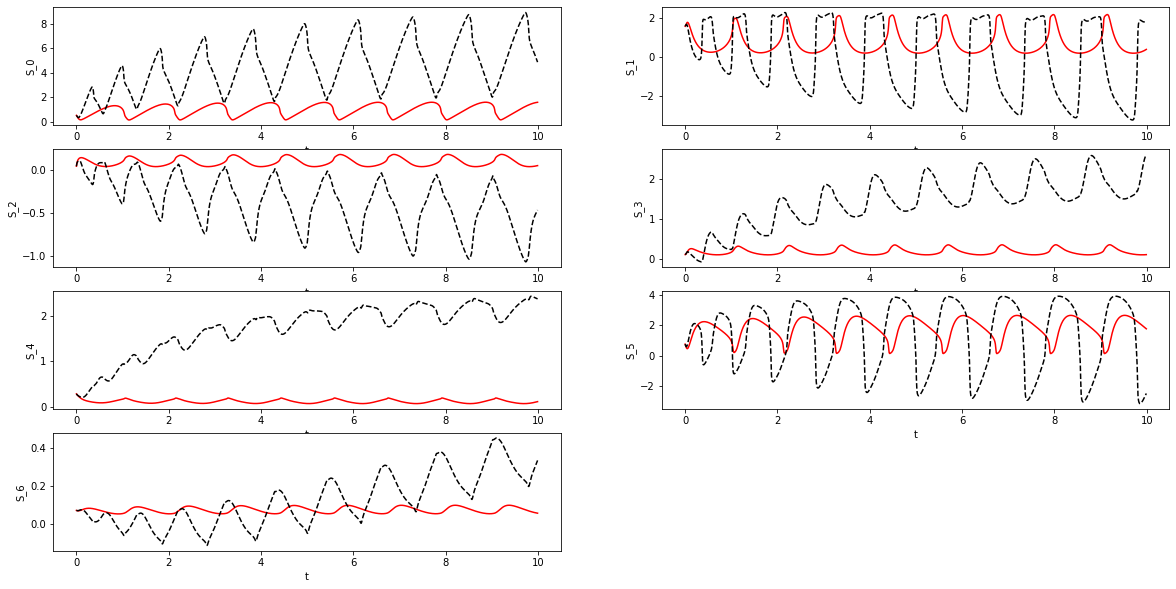

In [2]:
plt.figure(figsize=(20, 10))
for species in range(7):
    plt.subplot(4,2,species + 1)
    plt.plot(t_star, X_star[:, species], 'r-')
    plt.plot(t_star, learned_X_star[:,species], 'k--')
    plt.xlabel('t')
    plt.ylabel('S_' + str(species))